In [ ]:
#Installing Dependencies
!pip install tensorflow-io[tensorflow]

In [15]:
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
#Ensuring Files Exist
CAPUCHIN_FILE = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

print("CAPUCHIN_FILE exists:", os.path.exists(CAPUCHIN_FILE))
print("NOT_CAPUCHIN_FILE exists:", os.path.exists(NOT_CAPUCHIN_FILE))

CAPUCHIN_FILE exists: True
NOT_CAPUCHIN_FILE exists: True


In [18]:
#Loading And Converting Sampling Rate Of Audio To 16KHz
def load_wav_16k_mono(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

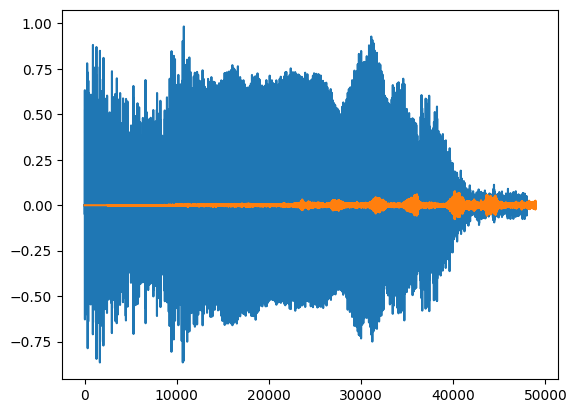

In [20]:
#Visualizing The Difference Between Presence And Abscence Of Call
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [21]:
#Loading Data From Positive And Negative Examples
POS = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Not_Capuchinbird_Clips')

pos = tf.data.Dataset.list_files(POS + '/*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*.wav')

#Balacing The Dataset By Reducing Negative Samples
#neg = neg.shuffle(700).take(222)

In [22]:
#855 samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

#Assign Class Weights For Imbalanced Dataset
from sklearn.utils.class_weight import compute_class_weight

# Count samples
num_positives = len(pos)
num_negatives = len(neg)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced",
                                    classes=np.array([0, 1]),
                                    y=np.array([0] * num_negatives + [1] * num_positives))

# Convert to dictionary
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
class_weights_dict[0] = 1
class_weights_dict[1] = 1.3

print("Class Weights:", class_weights_dict)

Class Weights: {0: 1, 1: 1.3}


In [23]:
data = positives.concatenate(negatives)

In [ ]:
#Calculating Average Clip Length
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join('drive', 'MyDrive', ' CCD_Data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54126>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [24]:
#Preprocessing Wav Into Spectrogram
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.ensure_shape(spectrogram, [1491, 257, 1])

    return spectrogram, label

In [ ]:
#Visualizing A Random Sample
filepath, label = positives.shuffle(buffer_size=400).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

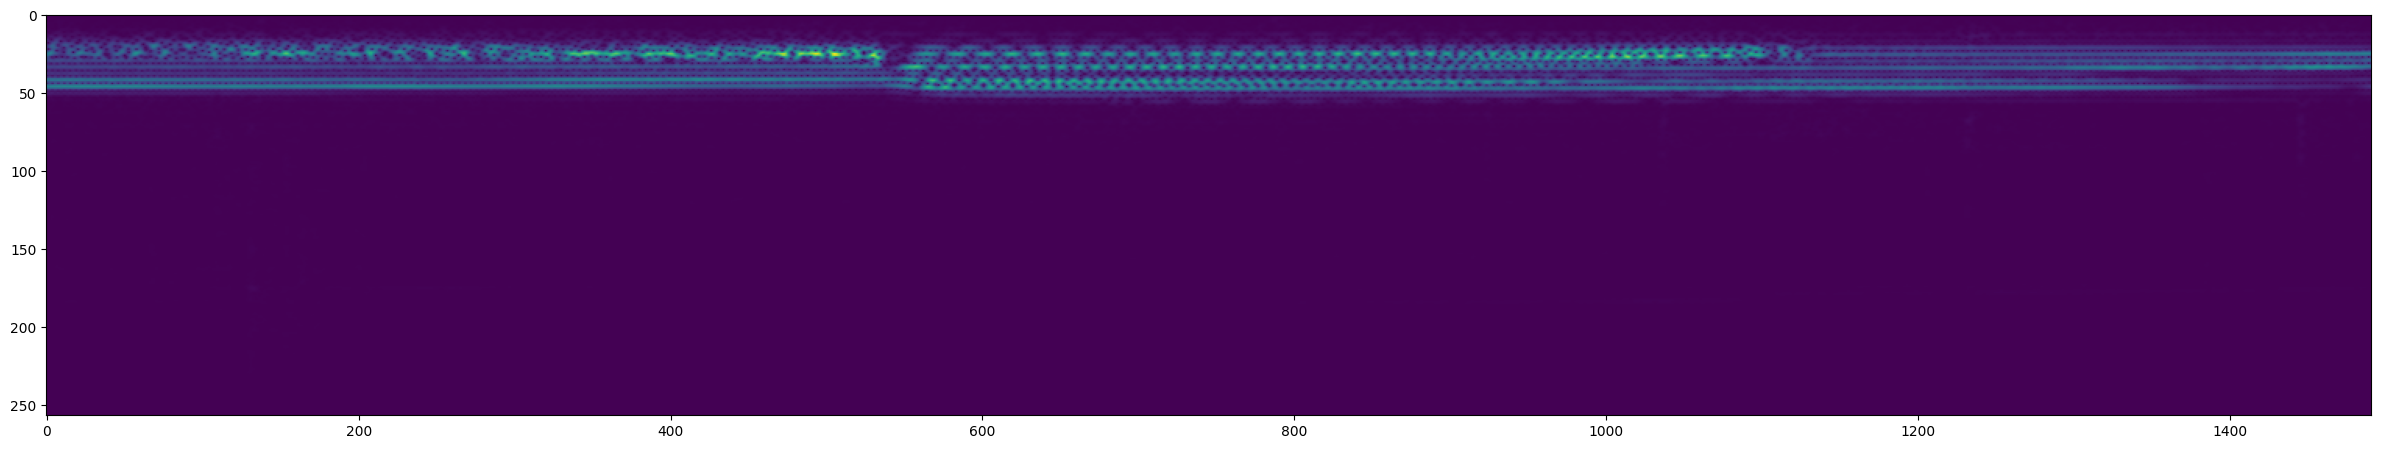

In [26]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
#Applying Preprocessing To Each Sample
data = data.map(preprocess)

# Apply Shuffle
data = data.shuffle(425).cache()

# Splitting Before Batching
train_size = 600
train_data = data.take(train_size)
test_data = data.skip(train_size).take(255)

#Batching And Prefetching
train = train_data.batch(16).prefetch(8)
test = test_data.batch(16).prefetch(8)

In [ ]:
#Loading Sample
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [ ]:
#Building CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Input, GlobalMaxPooling2D, MaxPooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [ ]:
K.clear_session()

model = Sequential()

model.add(Input(shape=(1491, 257, 1)))

model.add(Conv2D(8, (3,3), activation='relu'))
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.2))

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((3,3)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
#Configuring Callbacks, Loss Metrics and Compiling
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#Loss Metric For Imbalanced Dataset
'''
def tversky_loss(alpha=0.8, beta=0.2):
    def loss(y_true, y_pred):
        smooth = 1e-6
        tp = tf.reduce_sum(y_true * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        return 1 - (tp + smooth) / (tp + alpha * fn + beta * fp + smooth)
    return loss
'''

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 8)        │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 496, 85, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 496, 85, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 494, 83, 16)         │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 164, 27, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 164, 27, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 162, 25, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 8, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 54, 8, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 13824)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,769,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,775,617 (6.77 MB)

 Trainable params: 1,775,617 (6.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
hist = model.fit(train, epochs=15, validation_data=test, callbacks=[early_stopping], class_weight=class_weights_dict)
model.save("drive/MyDrive/ CCD_Data/model_2.keras")

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 313s 7s/step - accuracy: 0.8129 - loss: 0.5188 - precision: 0.7301 - recall: 0.8665 - val_accuracy: 0.9373 - val_loss: 0.1850 - val_precision: 0.8649 - val_recall: 0.7442
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - accuracy: 0.9047 - loss: 0.2482 - precision: 0.8995 - recall: 0.8353 - val_accuracy: 0.9569 - val_loss: 0.1390 - val_precision: 0.9211 - val_recall: 0.8140
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.9450 - loss: 0.1708 - precision: 0.9648 - recall: 0.8849 - val_accuracy: 0.9451 - val_loss: 0.1401 - val_precision: 0.8085 - val_recall: 0.8837
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 194s 4s/step - accuracy: 0.9711 - loss: 0.1340 - precision: 0.9612 - recall: 0.9559 - val_accuracy: 0.9569 - val_loss: 0.1010 - val_precision: 0.8636 - val_recall: 0.8837
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 177s 5s/step - accuracy: 0.9760 - loss: 0.0901 - precision: 0.9659 - recall: 0.9633 - val_accuracy: 0.9765 - val_loss: 0.0785 - val_preci

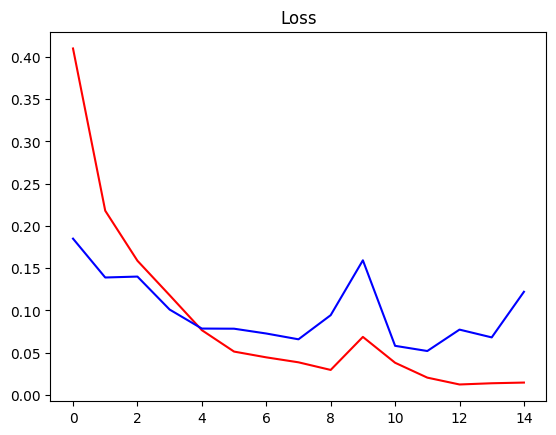

In [28]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

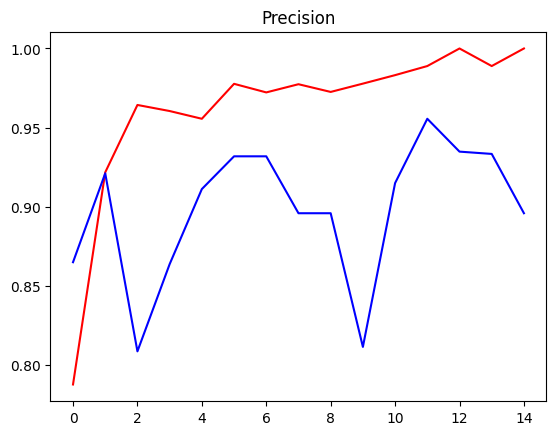

In [29]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

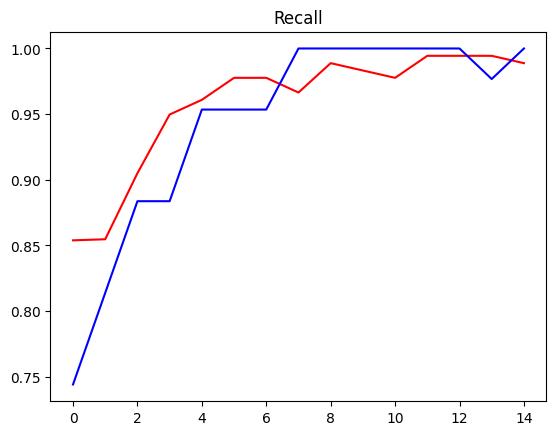

In [30]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [31]:
from tensorflow import keras
model = keras.models.load_model('drive/MyDrive/ CCD_Data/model_2.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 8)        │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 496, 85, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 496, 85, 8)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 494, 83, 16)         │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 164, 27, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 164, 27, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 162, 25, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 54, 8, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 54, 8, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 13824)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,769,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,326,853 (20.32 MB)

 Trainable params: 1,775,617 (6.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,551,236 (13.55 MB)

In [32]:
#Predict A Batch
X_test, y_test = test.as_numpy_iterator().next()
yhat = model.predict(X_test)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [33]:
print(yhat)
print(y_test)

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]


In [34]:
#Loading Audio Files
def load_mp3_16k_mono(filename):
    res = tfio.audio.AudioIOTensor(filename)
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [35]:
#Load A Sample
mp3 = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Forest Recordings', 'recording_00.mp3')
wav = load_mp3_16k_mono(mp3)
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [36]:
len(audio_slices)

60

In [37]:
#Preprocessing Function For Audio Files
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.ensure_shape(spectrogram, [1491, 257, 1])

    return spectrogram

In [38]:
#Convert First Example To Slices For Prediction
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [39]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [40]:
#True: 5
#Predictted: 5
tf.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [41]:
#Removes Consecutive Duplicates
from itertools import groupby
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()
print(calls) #Predicts Correctly For First Example

5


In [42]:
#Predictions For Every File Appended To A List
results = {}
for file in os.listdir(os.path.join('drive', 'MyDrive', ' CCD_Data', 'Forest Recordings')):
    FILEPATH = os.path.join('drive', 'MyDrive', ' CCD_Data', 'Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [43]:
#Convert Probabilites To Classes
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]

In [44]:
#Remove Consecutive Duplicates
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 10,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 3,
 'recording_05.mp3': 0,
 'recording_06.mp3': 4,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 2,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 1,
 'recording_16.mp3': 3,
 'recording_17.mp3': 3,
 'recording_19.mp3': 0,
 'recording_18.mp3': 1,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 4,
 'recording_24.mp3': 0,
 'recording_27.mp3': 0,
 'recording_25.mp3': 1,
 'recording_26.mp3': 2,
 'recording_28.mp3': 4,
 'recording_29.mp3': 0,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 1,
 'recording_34.mp3': 4,
 'recording_33.mp3': 0,
 'recording_35.mp3': 0,
 'recording_38.mp3': 1,
 'recording_37.mp3': 2,
 'recording_36.mp3': 0,
 'recording_40.mp3': 1,
 'recording_39.mp3': 2,
 'recording_41

In [45]:
#Write Predictions To A CSV File
import csv
with open('drive/MyDrive/ CCD_Data/predictions.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])

In [47]:
#Import Ground Truth
with open('drive/MyDrive/ CCD_Data/results.csv', mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    data_actual = [row for row in reader]

#Import Prediction
with open('drive/MyDrive/ CCD_Data/predictions.csv', mode="r", encoding="utf-8") as file:
    reader = csv.DictReader(file)
    data_pred = [row for row in reader]

In [52]:
total_error = sum(abs(float(row1['capuchin_calls']) - float(row2['capuchin_calls'])) for row1, row2 in zip(data_actual, data_pred))
print("Total Error:", total_error)

Total Error: 213.0
